# The irreducible mass of black holes.

Consider a rotating black hole. In 1969, Roger Penrose (now Nobel Prize in Physics for the theory of black holes) discovered that one can extract energy from a rotating black hole:  
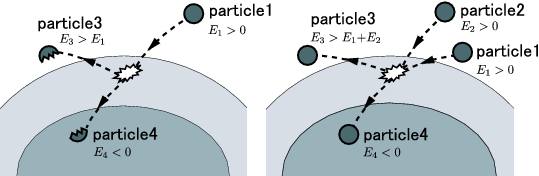  

For a BH of mass $M$ and spin $\chi\in[0,1]$, the irreducible mass is  
<center>$M_{irr} = M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$</center>  
For convenience let us define  
<center>$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{irr}}{M} $</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import norm
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import re
import math
import latexify

Let's assume that
- the spin $\chi$ is uniformly distributed between 0 and 1
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$  

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

Start with a value of $\sigma = 0.02$. This is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. I just set $\mu = 1$ in my code and remember that all masses in the problem are measured in units of $\mu$.

In [2]:
mu = 1
sigma = 0.02
N = 10000
spin = np.random.uniform(0, 1, N)
M = norm(mu, sigma).rvs(N)

In [3]:
M_irr = M * np.sqrt( (1 + np.sqrt(1-spin**2)) / 2 )

I plot the resulting $M_{irr}$. First try an histogram with one the rules of thumb we've seen above.

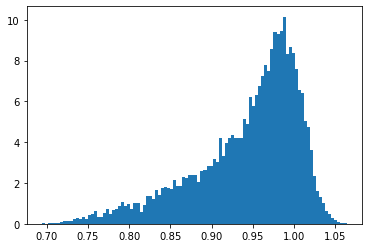

In [4]:
plt.hist(M_irr, bins=100, density=True)
plt.show()

In [5]:
x = np.linspace(M_irr.min(), M_irr.max(), 100)

Using the same samples, i plot the distribution of $M_{irr}$ using a KDE.

In [6]:
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

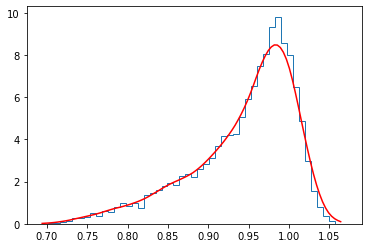

In [7]:
PDFtophat_M = kde_sklearn(M_irr, bandwidth=0.03, kernel="epanechnikov")
h_Mirr = fancyhist(M_irr, bins="freedman", histtype="step",density=True)
plt.plot(x, PDFtophat_M, color='red')
plt.show()

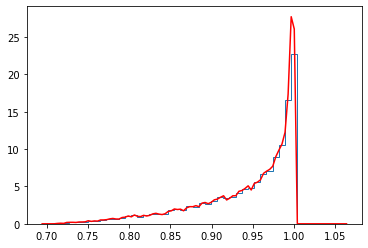

In [8]:
f = M_irr / M
PDFtophat_f = kde_sklearn(f, bandwidth=0.0035, kernel="epanechnikov")
h_f = fancyhist(f, bins="freedman", histtype="step",density=True)
plt.plot(x, PDFtophat_f, color='red')
plt.show()

In [9]:
counts_Mirr, bin_edges_Mirr = np.histogram(M_irr, bins=100, density=True)
pdf_Mirr = counts_Mirr / np.sum(counts_Mirr)
cdf_Mirr = np.cumsum(pdf_Mirr)

counts_f, bin_edges_f = np.histogram(f, bins=100, density=True)
pdf_f = counts_f / np.sum(counts_f)
cdf_f = np.cumsum(pdf_f)

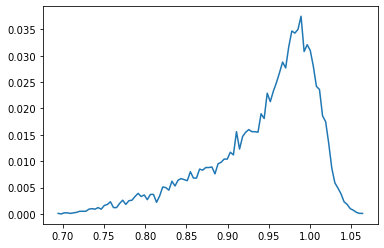

In [10]:
plt.plot(x, pdf_Mirr)
plt.show()

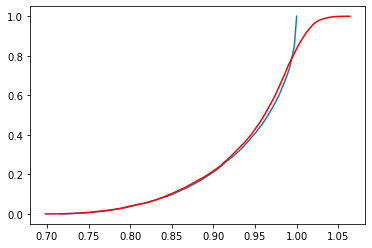

In [11]:
plt.plot(bin_edges_f[1:], cdf_f)
plt.plot(bin_edges_Mirr[1:], cdf_Mirr, color='red')

plt.show()

I compute the KS distance between $M_{irr}$ and $f$ as a function of $\sigma$ and between $M_{irr}$ and $M$ as a function of $\sigma$.

In [12]:
D_fMirr = max(abs(cdf_f - cdf_Mirr))
print(D_fMirr)

counts_M, bin_edges_M = np.histogram(M, bins=100, density=True)
pdf_M = counts_M / np.sum(counts_M)
cdf_M = np.cumsum(pdf_M)

D_MMirr = max(abs(cdf_M - cdf_Mirr))
print(D_MMirr)

0.4600999999999996
0.5669000000000008


I compute the KS distance while varying the sigma values and i discuss the limits at large and small values of $\sigma$.

In [13]:
sigmas = np.arange(0.001, 10, 0.005)
num = 10000

In [14]:
ks_fMirr_vec = []
ks_MMirr_vec = []

pbar = tqdm(total=len(sigmas), desc='for loop')
for s in sigmas:
    spins = np.random.uniform(0, 1, num)
    mass = norm(mu, s).rvs(num)
    irr_mass = mass * np.sqrt( (1 + np.sqrt(1-spin**2)) / 2 )
    
    f_ = irr_mass / mass
    
    ks_fMirr = stats.kstest(f_, irr_mass)
    ks_fMirr_vec.append(ks_fMirr)
    ks_MMirr = stats.kstest(mass, irr_mass)
    ks_MMirr_vec.append(ks_MMirr)
    
    pbar.update(s)
    
pbar.close()

for loop: 9996.999999999993it [00:49, 202.42it/s]                             


In [15]:
stat_fMirr = [result.statistic for result in ks_fMirr_vec]
stat_MMirr = [result.statistic for result in ks_MMirr_vec]

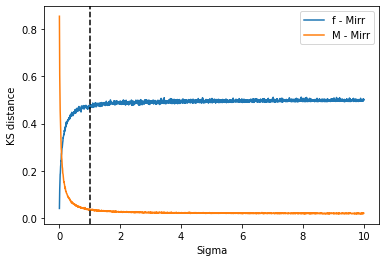

In [16]:
plt.plot(sigmas, stat_fMirr, label='f - Mirr')
plt.plot(sigmas, stat_MMirr, label='M - Mirr')
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel('Sigma')
plt.ylabel('KS distance')
plt.legend()
plt.show()

I can notice that $M_{irr}$ is distributed like $f$ if $\sigma \ll \mu$ and $M_irr$ is distributed like $M$ if $\sigma \gg \mu$.